***Drug Classifier Model Training***

In [135]:
# Importing libraries
import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, label_binarize
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
from itertools import cycle
from joblib import dump
import json
import seaborn as sns
import joblib

# Neural Network libraries
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

In [136]:
# Loading data and printing first 5 rows
pd = pd.read_csv('c:/Users/Nicolle School/-Database---Prediction-Pipeline---Group-11/data/drug200.csv')
pd.head()

,Age,Sex,BP,Cholesterol,Na_to_K,Drug
0,23,F,HIGH,HIGH,25.355,DrugY
1,47,M,LOW,HIGH,13.093,drugC
2,47,M,LOW,HIGH,10.114,drugC
3,28,F,NORMAL,HIGH,7.798,drugX
4,61,F,LOW,HIGH,18.043,DrugY


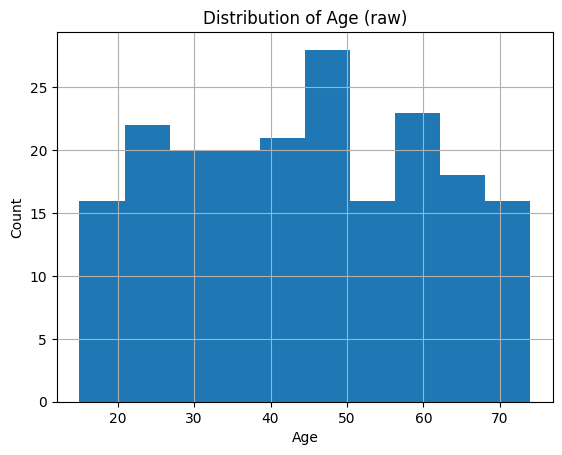

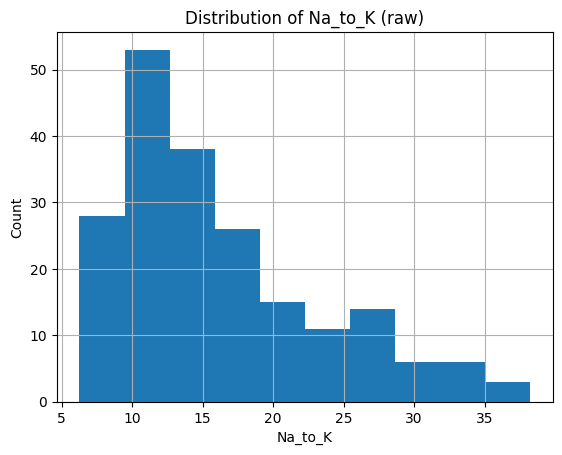

In [137]:
# Plot distributions for numerical features before scaling
numerical_features = ["Age", "Na_to_K"]
for feature in numerical_features:
    plt.figure()
    pd[feature].hist()
    plt.title(f"Distribution of {feature} (raw)")
    plt.xlabel(feature)
    plt.ylabel("Count")
    plt.show()

In [138]:
# Splitting data into training, testing and validation sets
X = pd.drop("Drug", axis=1)
y = pd["Drug"]

X_train_full, X_test, y_train_full, y_test = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=42
)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, test_size=0.25, stratify=y_train_full, random_state=42
)  # 60:20:20

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_val shape:", X_val.shape)
print("y_val shape:", y_val.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (120, 5)
y_train shape: (120,)
X_val shape: (40, 5)
y_val shape: (40,)
X_test shape: (40, 5)
y_test shape: (40,)


In [139]:
# Preprocessing, scaling numerical features and encoding categorical features
numerical_features = ["Age", "Na_to_K"]
categorical_features = ["Sex", "BP", "Cholesterol"]

num_pipeline = Pipeline(
    [
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler()),
    ]
)

cat_pipeline = Pipeline(
    [
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("one_hot", OneHotEncoder(handle_unknown="ignore")),
    ]
)

preprocessor = ColumnTransformer(
    [
        ("num", num_pipeline, numerical_features),
        ("cat", cat_pipeline, categorical_features),
    ]
)

#Scaling numerical features
scaling_features = ["Age", "Na_to_K"]
scaler = StandardScaler()

X_train[scaling_features] = scaler.fit_transform(X_train[scaling_features])
X_val[scaling_features] = scaler.transform(X_val[scaling_features])
X_test[scaling_features] = scaler.transform(X_test[scaling_features])

**Models Training and Choosing Best Model**

c:\Users\Nicolle School\-Database---Prediction-Pipeline---Group-11\venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1264: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Classification Report:
              precision    recall  f1-score   support

       DrugY       0.81      0.94      0.87        18
       drugA       1.00      0.60      0.75         5
       drugB       1.00      0.67      0.80         3
       drugC       1.00      0.67      0.80         3
       drugX       0.83      0.91      0.87        11

    accuracy                           0.85        40
   macro avg       0.93      0.76      0.82        40
weighted avg       0.87      0.85      0.85        40



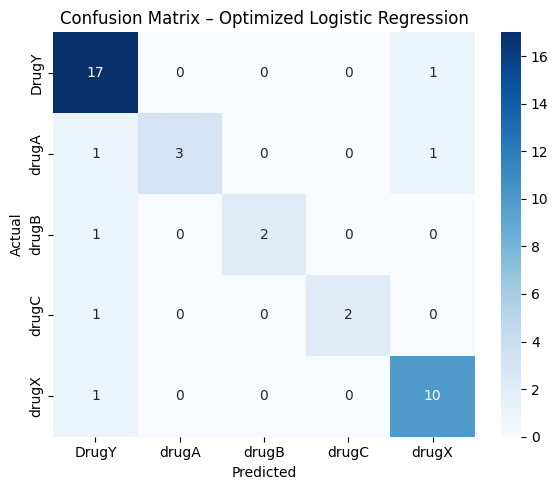

ROC‑AUC (macro‑average): 0.9958
Optimized model saved to: saved_models/model_logreg_optimized.pkl
Logistic Regression
Best Params: {'model__C': 0.25, 'model__max_iter': 1000}
Validation Accuracy: 0.875


In [140]:
# Logistic Regression Model
logreg_pipe = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", LogisticRegression(max_iter=1000, multi_class="multinomial", n_jobs=-1))
])

# Hyperparameter grid
logreg_grid = {
    "model__C": [0.001, 0.05, 0.25, 0.1],
    "model__max_iter": [1000]
}

# Grid Search
grid_logreg = GridSearchCV(logreg_pipe, param_grid=logreg_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_logreg.fit(X_train, y_train)

# Evaluating
logreg_best = grid_logreg.best_estimator_
logreg_val_pred = logreg_best.predict(X_val)
logreg_val_acc = accuracy_score(y_val, logreg_val_pred)

# Class names
class_names = np.sort(y.unique())

# Predictions
y_pred        = logreg_best.predict(X_test)
y_pred_proba  = logreg_best.predict_proba(X_test) 

print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=class_names.astype(str)))

# Confusion matrix heatmap
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=class_names,
    yticklabels=class_names
)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix – Optimized Logistic Regression")
plt.tight_layout()
plt.show()

# Binarize true labels for ROC computation
y_test_bin = label_binarize(y_test, classes=class_names)

roc_auc = roc_auc_score(y_test_bin, y_pred_proba, average='macro', multi_class='ovr')
print(f"ROC‑AUC (macro‑average): {roc_auc:.4f}")

# 5. Save the optimized model
Path("saved_models").mkdir(exist_ok=True)
model_path = "saved_models/model_logreg_optimized.pkl"
joblib.dump(logreg_best, model_path)
print(f"Optimized model saved to: {model_path}")

print("Logistic Regression")
print("Best Params:", grid_logreg.best_params_)
print("Validation Accuracy:", logreg_val_acc)



Gradient Boosting - Classification Report:
              precision    recall  f1-score   support

       DrugY       0.90      1.00      0.95        18
       drugA       1.00      0.80      0.89         5
       drugB       1.00      1.00      1.00         3
       drugC       1.00      1.00      1.00         3
       drugX       1.00      0.91      0.95        11

    accuracy                           0.95        40
   macro avg       0.98      0.94      0.96        40
weighted avg       0.96      0.95      0.95        40



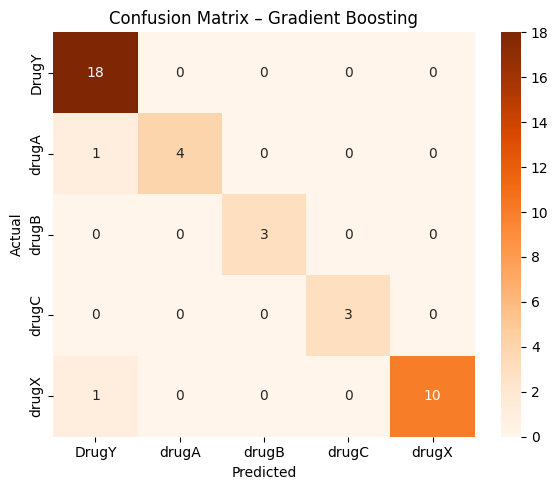

ROC AUC (macro-average): 0.9952
Gradient Boosting model saved to: {gb_model_path}
Gradient Boosting
Best Params: {'model__learning_rate': 0.05, 'model__n_estimators': 100}
Validation Accuracy: 0.975


In [141]:
# Gradient Boosting Model
gb_pipe = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", GradientBoostingClassifier(random_state=42))
])

# Hyperparameter grid
gb_grid = {
    "model__n_estimators": [50, 100, 200],
    "model__learning_rate": [0.001, 0.05, 0.1]
}

# Grid Search
grid_gb = GridSearchCV(gb_pipe, param_grid=gb_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_gb.fit(X_train, y_train)

# Evaluating
gb_best = grid_gb.best_estimator_
gb_val_pred = gb_best.predict(X_val)
gb_val_acc = accuracy_score(y_val, gb_val_pred)

# 2. Class names
class_names = np.sort(y.unique())

# Predictions
gb_y_pred = gb_best.predict(X_test)
gb_y_pred_proba = gb_best.predict_proba(X_test)

# 3. Classification report
print("Gradient Boosting - Classification Report:")
print(classification_report(y_test, gb_y_pred, target_names=class_names.astype(str)))

# 4. Confusion matrix heatmap
cm = confusion_matrix(y_test, gb_y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix – Gradient Boosting")
plt.tight_layout()
plt.show()

# ROC AUC (macro)
y_test_bin = label_binarize(y_test, classes=class_names)
roc_auc = roc_auc_score(y_test_bin, gb_y_pred_proba, average='macro', multi_class='ovr')
print(f"ROC AUC (macro-average): {roc_auc:.4f}")

# Save the model
Path("saved_models").mkdir(exist_ok=True)
gb_model_path = "saved_models/model_gb_optimized.pkl"
joblib.dump(gb_best, gb_model_path)
print("Gradient Boosting model saved to: {gb_model_path}")

print("Gradient Boosting")
print("Best Params:", grid_gb.best_params_)
print("Validation Accuracy:", gb_val_acc)


Random Forest - Classification Report:
              precision    recall  f1-score   support

       DrugY       0.95      1.00      0.97        18
       drugA       1.00      1.00      1.00         5
       drugB       1.00      1.00      1.00         3
       drugC       1.00      1.00      1.00         3
       drugX       1.00      0.91      0.95        11

    accuracy                           0.97        40
   macro avg       0.99      0.98      0.99        40
weighted avg       0.98      0.97      0.97        40



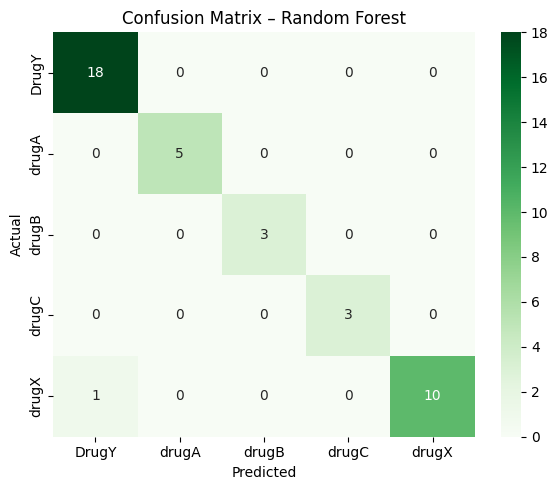

ROC AUC (macro-average): 0.9800
Random Forest model saved to: saved_models/model_rf_optimized.pkl
Random Forest
Best Params: {'model__max_depth': 5, 'model__n_estimators': 10}
Validation Accuracy: 0.925


In [142]:
# Random Forest Model
rf_pipe = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", RandomForestClassifier(random_state=42))
])

# Hyperparameter grid
rf_grid = {
    "model__n_estimators": [5, 10],
    "model__max_depth": [None, 2, 5, 10]
}

# Grid Search
grid_rf = GridSearchCV(rf_pipe, param_grid=rf_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_rf.fit(X_train, y_train)

# Evaluating
rf_best = grid_rf.best_estimator_
rf_val_pred = rf_best.predict(X_val)
rf_val_acc = accuracy_score(y_val, rf_val_pred)

# Predictions
rf_y_pred = rf_best.predict(X_test)
rf_y_pred_proba = rf_best.predict_proba(X_test)

# Class names
class_names = np.sort(y.unique())

# Classification report
print("Random Forest - Classification Report:")
print(classification_report(y_test, rf_y_pred, target_names=class_names.astype(str)))

# Confusion matrix heatmap
cm = confusion_matrix(y_test, rf_y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix – Random Forest")
plt.tight_layout()
plt.show()

# ROC AUC (macro)
y_test_bin = label_binarize(y_test, classes=class_names)
roc_auc = roc_auc_score(y_test_bin, rf_y_pred_proba, average='macro', multi_class='ovr')
print(f"ROC AUC (macro-average): {roc_auc:.4f}")

# Save model
Path("saved_models").mkdir(exist_ok=True)
rf_model_path = "saved_models/model_rf_optimized.pkl"
joblib.dump(rf_best, rf_model_path)
print(f"Random Forest model saved to: {rf_model_path}")

print("Random Forest")
print("Best Params:", grid_rf.best_params_)
print("Validation Accuracy:", rf_val_acc)

Epoch 1/30


c:\Users\Nicolle School\-Database---Prediction-Pipeline---Group-11\venv\Lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.4874 - loss: 1.4874 - val_accuracy: 0.3250 - val_loss: 1.5489
Epoch 2/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.4637 - loss: 1.4571 - val_accuracy: 0.3500 - val_loss: 1.4799
Epoch 3/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5034 - loss: 1.3707 - val_accuracy: 0.4500 - val_loss: 1.4149
Epoch 4/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5553 - loss: 1.2926 - val_accuracy: 0.4500 - val_loss: 1.3542
Epoch 5/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5611 - loss: 1.1872 - val_accuracy: 0.5000 - val_loss: 1.2966
Epoch 6/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5577 - loss: 1.1687 - val_accuracy: 0.4750 - val_loss: 1.2423
Epoch 7/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5854 - loss: 1.1712 - val_accuracy: 0.5250 - val_loss: 1.1921
Epoch 8/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5940 - loss: 1.0863 - val_accuracy: 0.5500 - val_loss: 1.1462
Epoch 9/30
8/8

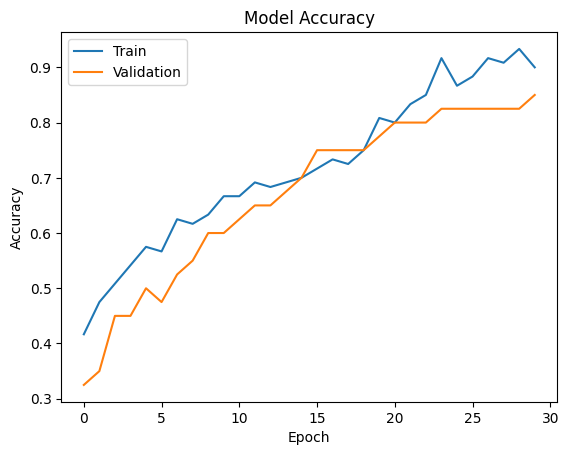

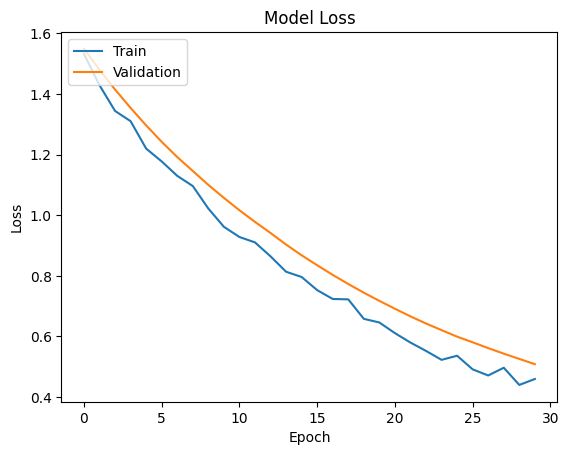

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Neural Network - Classification Report:
              precision    recall  f1-score   support

       DrugY       0.84      0.89      0.86        18
       drugA       1.00      0.80      0.89         5
       drugB       1.00      0.67      0.80         3
       drugC       1.00      0.67      0.80         3
       drugX       0.85      1.00      0.92        11

    accuracy                           0.88        40
   macro avg       0.94      0.80      0.85        40
weighted avg       0.89      0.88      0.87        40



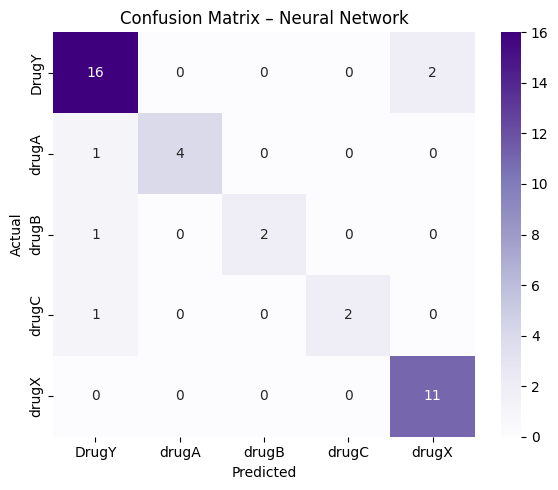

ROC AUC (macro-average): 0.9906
Neural Network model saved to: saved_models/model_nn_optimized.keras
Neural Network
Validation Accuracy: 0.8500000238418579


In [144]:
# Neural Network Model
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_proc.shape[1],)),
    Dropout(0.2),
    Dense(5, activation='softmax')
])

# Define learning rate scheduler
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

# Compile the model
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Define early stopping
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

# Encode labels to integers
unique_classes = sorted(y_train.unique())
class_to_index = {label: i for i, label in enumerate(unique_classes)}

y_train_enc = y_train.map(class_to_index).values
y_val_enc = y_val.map(class_to_index).values

# Train and show training progress per epoch
history = model.fit(
    X_train_proc, y_train_enc,
    validation_data=(X_val_proc, y_val_enc),
    epochs=30,
    batch_size=16,
    callbacks=[early_stop],
    verbose=1 
)

# Plot training and validation accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training and validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# 1. Prepare test labels and predictions
y_test_enc = y_test.map(class_to_index).values
nn_y_pred_proba = model.predict(X_test_proc)        
nn_y_pred = np.argmax(nn_y_pred_proba, axis=1)                 

# 2. Classification report
print("Neural Network - Classification Report:")
print(classification_report(y_test_enc, nn_y_pred, target_names=list(class_to_index.keys())))

# 3. Confusion matrix
cm = confusion_matrix(y_test_enc, nn_y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Purples',
            xticklabels=list(class_to_index.keys()),
            yticklabels=list(class_to_index.keys()))
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix – Neural Network")
plt.tight_layout()
plt.show()

# ROC AUC (macro-average)
y_test_bin = label_binarize(y_test_enc, classes=list(range(len(class_to_index))))
roc_auc = roc_auc_score(y_test_bin, nn_y_pred_proba, average='macro', multi_class='ovr')
print(f"ROC AUC (macro-average): {roc_auc:.4f}")

# Save the model
Path("saved_models").mkdir(exist_ok=True)
nn_model_path = "saved_models/model_nn_optimized.keras"
model.save(nn_model_path)

print(f"Neural Network model saved to: {nn_model_path}")
print("Neural Network")
print("Validation Accuracy:", history.history['val_accuracy'][-1])